# Data Lake with Spark: working with I94 Immigration Data
### Data Engineering Capstone Project
By creating an ETL pipeline of I94 immigration data of the U.S. in year 2016, the aim of this project is to gain an analytical of the origin of immigrants and their immigration destinations in U.S.. 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

## Step 1: Scope the Project and Gather Data

### Scope 
The technologies used in this project are **AWS EMR**, **AWS S3** and **Apache Spark**
1. Datasets were first uploaded to personal Amazon S3
1. with EMR cluster, use spark to load datasets and perform data transformation
2. create and fact and dimension tables that have shared foreign keys
3. write the fact and dimension tables in S3 for future analytics tasks

The creation of the data model allows us to study:
* Where did the immigrants come from? A cold place or a hot place?
* What were the purposes of immigration?
* What were their favourite immigration destination(s)? 
* Are there anything special (attitude, composition of the population) about these destinations? 

### Describe and Gather Data 
Datasets to work on:
* I94 Immigration Data of year 2016: came from the US National Tourism and Trade Office.  You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.

Supplementary data:
* Dictionary file for column names in I94 Data mmigration Data
* World Temperature Data: comes from Kaggle. It reports the daily temperature since 1700s for most cities in the world.
* U.S. City Demographic Data: comes from OpenSoft. It records the demographics data (e.g. % female, mean age, etc) of all cities in U.S.
* Airport Code Table: comes from [here](https://datahub.io/core/airport-codes#data).It records the airport in U.S.

### Import libaries

In [2]:
# Do all imports and installs here
import pandas as pd
pd.set_option('display.max_columns', 999)

from pyspark.sql import SparkSession

import funcs 


#### Create a *SparkSession*
For reading SAS files and csv files

In [3]:
spark=SparkSession.builder.\
    config("spark.jars.packages","saurfang:spark-sas7bdat:3.0.0-s_2.12")\
.enableHiveSupport().getOrCreate()
spark

### Read immigration dataset with *Spark*

In [4]:
# as an example, We only read the data from April 2016
immigration='data/immigration/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
df_immigration =spark.read.format('com.github.saurfang.sas.spark').load(immigration)

In [17]:
df_immigration.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,37.0,2.0,1.0,None,None,None,T,None,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,25.0,3.0,1.0,20130811,SEO,None,G,None,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,20160401,None,None,T,O,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,28.0,2.0,1.0,20160401,None,None,O,O,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,4.0,2.0,1.0,20160401,None,None,O,O,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [43]:
df_immigration.agg({'cicid':'max'}).collect()[0]

Row(max(cicid)=6102785.0)

In [5]:
df_immigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [12]:
# print total number of records in df_immigration
print (df_immigration.count())

3096313


### Read SAS description file and extract useful info in dict

In [4]:
i94des='data/immigration/I94_SAS_Labels_Descriptions.SAS'
with open(i94des) as f:
    f_content = f.read()
    f_content = f_content.replace('\t', '')
def code_mapper(file, idx):
    f_content2 = f_content[f_content.index(idx):]
    f_content2 = f_content2[:f_content2.index(';')].split('\n')
    f_content2 = [i.replace("'", "") for i in f_content2]
    dic = [i.split('=') for i in f_content2[1:]]
    dic = dict([i[0].strip(), i[1].strip()] for i in dic if len(i) == 2)
    return dic
i94cit_res = code_mapper(f_content, "i94cntyl")
i94port = code_mapper(f_content, "i94prtl")
i94mode = code_mapper(f_content, "i94model")
i94addr = code_mapper(f_content, "i94addrl")
i94visa = {'1':'Business',
    '2': 'Pleasure',
    '3' : 'Student'}

In [32]:
# display first 5 items in dictionaries
print (len(i94cit_res),dict(list(i94cit_res.items())[:5]))
print (len(i94port),dict(list(i94port.items())[:5]))
print (len(i94mode),dict(list(i94mode.items())[:5]))
print (len(i94addr),dict(list(i94addr.items())[:5]))

289 {'582': 'MEXICO Air Sea, and Not Reported (I-94, no land arrivals)', '236': 'AFGHANISTAN', '101': 'ALBANIA', '316': 'ALGERIA', '102': 'ANDORRA'}
660 {'ALC': 'ALCAN, AK', 'ANC': 'ANCHORAGE, AK', 'BAR': 'BAKER AAF - BAKER ISLAND, AK', 'DAC': 'DALTONS CACHE, AK', 'PIZ': 'DEW STATION PT LAY DEW, AK'}
4 {'1': 'Air', '2': 'Sea', '3': 'Land', '9': 'Not reported'}
55 {'AL': 'ALABAMA', 'AK': 'ALASKA', 'AZ': 'ARIZONA', 'AR': 'ARKANSAS', 'CA': 'CALIFORNIA'}


In [59]:
df_temp=spark2.read.csv('data/GlobalLandTemperaturesByCity.csv',header=True)
df_temp.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E
3,1744-02-01,None,None,Århus,Denmark,57.05N,10.33E
4,1744-03-01,None,None,Århus,Denmark,57.05N,10.33E


In [57]:
df_airport=spark2.read.csv('data/airport-codes_csv.csv',header=True)
df_airport.limit(5).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


In [60]:
df_airport.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [6]:
df_demographics=spark.read.csv('data/us-cities-demographics.csv',sep=';',header=True)
df_demographics.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.
* For each table, show % of missing values in barplot

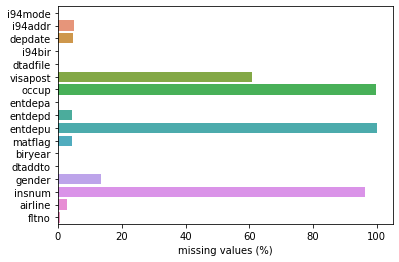

In [10]:
funcs.show_nan_spark(df_immigration)

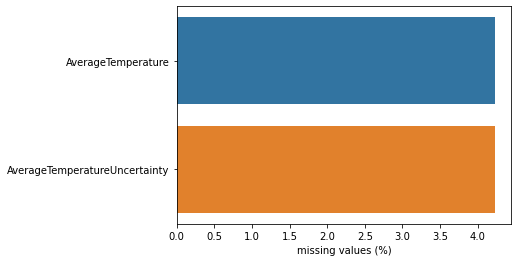

In [60]:
funcs.show_nan_spark(df_temp)

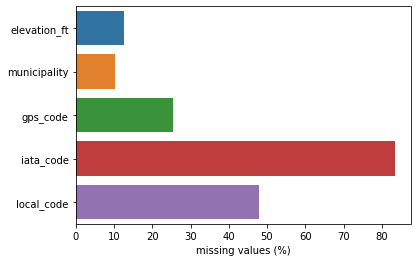

In [67]:
funcs.show_nan_spark(df_airport)

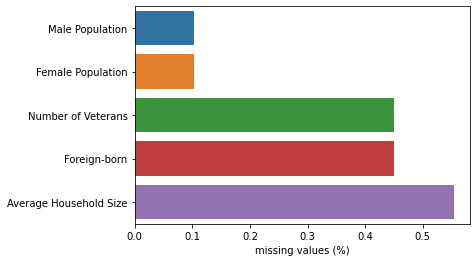

In [72]:
funcs.show_nan_spark(df_demographics)

#### Cleaning Steps
For each table, `clean_spark()` in `funcs.py` to
* remove columns with >50% missing values
* remove empty rows
* remove duplicated rows

In [68]:
# Because the demographics data is recorded for each race in a city, 
# 'City' and 'Race' were chosen as subset
# 'State' is also included to avoid cities from different state having the same name
# Because demographics contained few missing values, we drop any missing rows
funcs.clean_spark(df_demographics,dropna_mode='any',idx=['City','State','Race'])

df.shape before cleaning (2891,12)
len(df.columns) after dropping columns with >50% nan 12
df.count after dropping empty rows 2875
df.count after dropping duplicated rows 2875


DataFrame[City: string, State: string, Median Age: string, Male Population: string, Female Population: string, Total Population: string, Number of Veterans: string, Foreign-born: string, Average Household Size: string, State Code: string, Race: string, Count: string]

In [69]:
funcs.clean_spark(df_airport,dropna_mode='all',idx=['ident'])

df.shape before cleaning (55075,12)
len(df.columns) after dropping columns with >50% nan 11
df.count after dropping empty rows 55075
df.count after dropping duplicated rows 55075


DataFrame[ident: string, type: string, name: string, elevation_ft: string, continent: string, iso_country: string, iso_region: string, municipality: string, gps_code: string, local_code: string, coordinates: string]

In [70]:
# Because the temp is recorded for each date in a city, 
# 'City' and 'dt' were chosen as subset
# 'Country' is also included to avoid cities from different countries having the same name
# Because temp contained few missing values, we drop any missing rows
funcs.clean_spark(df_temp,dropna_mode='any',idx=['dt','City','Country'])

df.shape before cleaning (8599212,7)
len(df.columns) after dropping columns with >50% nan 7
df.count after dropping empty rows 8235082
df.count after dropping duplicated rows 8190783


DataFrame[dt: string, AverageTemperature: string, AverageTemperatureUncertainty: string, City: string, Country: string, Latitude: string, Longitude: string]

In [54]:
# clean immigration table
funcs.clean_spark(df_immigration,dropna_mode='all',idx=['cicid'])  

df.shape before cleaning (3096313,28)
len(df.columns) after dropping columns with >50% nan 24
df.count after dropping empty rows 3096313
df.count after dropping duplicated rows 3096313


DataFrame[cicid: double, i94yr: double, i94mon: double, i94cit: double, i94res: double, i94port: string, arrdate: double, i94mode: double, i94addr: string, depdate: double, i94bir: double, i94visa: double, count: double, dtadfile: string, entdepa: string, entdepd: string, matflag: string, biryear: double, dtaddto: string, gender: string, airline: string, admnum: double, fltno: string, visatype: string]

## Step 3: Define the Data Model
### 3.1 Conceptual Data Model
The data model contains 1 fact table, and 4 dimensional tables. The dimension tables can be joined to the fact table via shared foreign key in later data analytics steps.

#### Fact table
The fact table `fact_immigration` is created from the immigration data. It include columns:


| colname  | dtype          | key  | value                               |
| -------- | -------------- | ---- | ----------------------------------- |
| cicid    | double         | PK   | identifier                          |
| i94cit   | double->string | FK   | 3-digit code country of citizenship |
| i94res   | double->string | FK   | 3-digit country of residence        |
| i94addr  | string         | FK   | destinatin state in US              |
| ...      | ...            | ...  | ...                                 |
| visatype | string         | FK   | visa type                           |


#### Dimension tables

* `dim_temp` is created from global temperature data. It is aggregated on country-level on average temperature in April of all cities. It connects to `i94cit` and `i94res` to fact table  via column `country_code`.

| colname        | dtype  | key  | value                                                        |
| -------------- | ------ | ---- | ------------------------------------------------------------ |
| country_code   | string | FK   | 3-digit code of country                                      |
| Country        | string | PK   | country name in BLOCK letters                                |
| avg_temp_april | double |      | average temperature in april for all recorded dates, aggregated at country level |

* `dim_airport` is created from airport data. It shows only airport inside US. It connects to `i94_port` in fact table via column `local_code`.

| colname      | dtype       | key  | value                                             |
| ------------ | ----------- | ---- | ------------------------------------------------- |
| ident        | string      | PK   | identifier of airport                             |
| local_code   | string      | FK   | non-nan local code of airport                     |
| iso_country  | string      |      | country name in BLOCK letters, all equals to 'US' |
| elevation_ft | string->int |      | elevation of airport                              |
| ...          | ...         | ...  | ...                                               |

* `dim_demographics` is created from demographics data in US. It shows cellular demographical information of up to state-city-race level. It connects to `i94addr`in fact table via column `State_code`.

| colname    | dtype       | key  | value                                                        |
| ---------- | ----------- | ---- | ------------------------------------------------------------ |
| State_code | string      | FK   | 2-syllable code of states in US                              |
| State      | string      |      | State in US                                                  |
| Race       | string      |      | categorical, one of 'Hispanic or Latino', 'White', 'Asian', 'Black or African-American', and 'American Indian and Alaska Native' |
| City       | string->int |      | City in a US state                                           |
| ...        | ...         | ...  | ...                                                          |

* `dim_visa` is created from immigration data during the normalisation of fact table. It provides supplementary information about the type of visa issue. It connects to `visatype` in fact table via column `visatype`.

| colname       | dtype          | key  | value                                                        |
| ------------- | -------------- | ---- | ------------------------------------------------------------ |
| visatype      | string         | FK   | 2-syllable code of visa types issued in US                   |
| i94_visa      | string->string |      | one-digit string of three ('1','2','3') condensed visa types, |
| i94_visa_info | string         |      | description of 'i94_visa'                                    |
| ...           | ...            | ...  | ...                                                          |

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model
1. load data with *Spark*
2. create fact table and dim tables
    1. clean data with `clean_spark` defined in `etl.py`
    3. normalisation of column name if necessary
3. write the table to parquet files

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
The ETL pipeline is defined in `etl.py`, together with `funcs.py` to creates final tables in Amazon S3.

In [ ]:
# aws
spark-submit --packages saurfang:spark-sas7bdat:3.0.0-s_2.12 etl.py aws

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks
* `funcs.clean_spark()` was run for every table to make sure a table has correct unique key definition and non-redundant unique rows;
* A local test is designed to run on immigration data in April only, before the actual run on AWS. Just run `etl.py` in local mode. 
* In `etl.py`, the number of rows and columns in a table were counted after each step. One can see immediately if it contains 0 rows;


In [5]:
# A local test run on April immigration data
%run etl.py local

table dim_airport
df.shape before cleaning (55075,12)
len(df.columns) after dropping columns with >50% nan 11
df.count after dropping empty rows 55075
df.count after dropping duplicated rows 55075
df inside US 22757
df local_code is not nan 21236


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

*Apache Spark* was chosen because of it ability to handle multiple file formats (sas, csv, parquets). It is also optimised for cluster computing on AWS.
* Propose how often the data should be updated and why.
The data will be updated monthly, because the immigration data is available at a monthly manner
* Write a description of how you would approach the problem differently under the following scenarios:
     * The data was increased by 100x.
     It is still possible to use AWS due to its horizontal scalability, though we can consider rent a cluster with more worker nodes.
 
     * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     *Apache Airflow* can be used to schedule, trigger, and visualise data pipelines at a regular interval
     * The database needed to be accessed by 100+ people.
     We will need to define new AWS access roles, to grant aws users access to data in S3.